In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim

In [8]:
class VeryTinyNeRFMLP(nn.Module):
    def __init__(self):
        super().__init__()
        # 定义位置编码和方向编码的层数
        self.L_pos = 6
        self.L_dir = 4

        # 计算位置编码和方向编码的特征维度
        pos_enc_feats = 3 + 3 * 2 * self.L_pos
        dir_enc_feats = 3 + 3 * 2 * self.L_dir

        # 神经网络的宽度
        net_width = 256

        # 初期多层感知机（处理位置编码）
        self.early_mlp = nn.Sequential(
            nn.Linear(pos_enc_feats, net_width),
            nn.ReLU(),
            nn.Linear(net_width, net_width + 1),
            nn.ReLU(),
        )

        # 后期多层感知机（结合方向编码）
        self.late_mlp = nn.Sequential(
            nn.Linear(net_width + dir_enc_feats, net_width),
            nn.ReLU(),
            nn.Linear(net_width, 3),
            nn.Sigmoid(),
        )

    def forward(self, xs, ds):
        # 对位置数据进行编码
        xs_encoded = [xs]
        for l_pos in range(self.L_pos):
            xs_encoded.append(torch.sin(2**l_pos * torch.pi * xs))
            xs_encoded.append(torch.cos(2**l_pos * torch.pi * xs))

        # 将编码后的位置数据合并
        xs_encoded = torch.cat(xs_encoded, dim=-1)

        # 对方向数据进行标准化处理
        ds = ds / ds.norm(p=2, dim=-1).unsqueeze(-1)
        ds_encoded = [ds]
        for l_dir in range(self.L_dir):
            ds_encoded.append(torch.sin(2**l_dir * torch.pi * ds))
            ds_encoded.append(torch.cos(2**l_dir * torch.pi * ds))

        # 将编码后的方向数据合并
        ds_encoded = torch.cat(ds_encoded, dim=-1)

        # 通过初期MLP处理位置编码
        outputs = self.early_mlp(xs_encoded)

        # 提取密度值(sigma)
        sigma_is = outputs[:, 0]

        # 结合方向编码，通过后期MLP处理，获取颜色值
        c_is = self.late_mlp(torch.cat([outputs[:, 1:], ds_encoded], dim=-1))

        # 返回结果，包括颜色和密度
        return {"c_is": c_is, "sigma_is": sigma_is}

In [9]:
class VeryTinyNeRF:
    def __init__(self, device):
        # 初始化NeRF的MLP模型并将其移动到指定的设备（如GPU）
        self.F_c = VeryTinyNeRFMLP().to(device)

        # 设置批处理大小
        self.chunk_size = 16384

        # 设置积分的起始和结束时间
        self.t_n = t_n = 1.0
        self.t_f = t_f = 4.0

        # 设置用于粗略渲染的样本点数量
        self.N_c = N_c = 32

        # 计算相邻样本点之间的时间间隔
        self.t_i_c_gap = t_i_c_gap = (t_f - t_n) / N_c

        # 计算积分时间的边界值
        self.t_i_c_bin_edges = (t_n + torch.arange(N_c) * t_i_c_gap).to(device)

    def get_coarse_query_points(self, ds, os):
        # 随机生成样本点的时间位置
        u_is_c = torch.rand(*list(ds.shape[:2]) + [self.N_c]).to(ds)

        # 计算实际的样本点时间位置
        t_is_c = self.t_i_c_bin_edges + u_is_c * self.t_i_c_gap

        # 计算样本点的空间位置
        r_ts_c = os[..., None, :] + t_is_c[..., :, None] * ds[..., None, :]
        return (r_ts_c, t_is_c)

    def render_radiance_volume(self, r_ts, ds, F, t_is):
        # 展平样本点和方向数据
        r_ts_flat = r_ts.reshape((-1, 3))
        ds_rep = ds.unsqueeze(2).repeat(1, 1, r_ts.shape[-2], 1)
        ds_flat = ds_rep.reshape((-1, 3))

        c_is = []
        sigma_is = []
        # 分批处理样本点
        for chunk_start in range(0, r_ts_flat.shape[0], self.chunk_size):
            r_ts_batch = r_ts_flat[chunk_start : chunk_start + self.chunk_size]
            ds_batch = ds_flat[chunk_start : chunk_start + self.chunk_size]

            # 使用MLP模型估计颜色和密度
            preds = F(r_ts_batch, ds_batch)
            c_is.append(preds["c_is"])
            sigma_is.append(preds["sigma_is"])

        # 重构颜色和密度矩阵
        c_is = torch.cat(c_is).reshape(r_ts.shape)
        sigma_is = torch.cat(sigma_is).reshape(r_ts.shape[:-1])

        # 计算相邻样本点间的距离
        delta_is = t_is[..., 1:] - t_is[..., :-1]
        one_e_10 = torch.Tensor([1e10]).expand(delta_is[..., :1].shape)
        delta_is = torch.cat([delta_is, one_e_10.to(delta_is)], dim=-1)
        delta_is = delta_is * ds.norm(dim=-1).unsqueeze(-1)

        # 计算透明度
        alpha_is = 1.0 - torch.exp(-sigma_is * delta_is)

        # 计算累积透明度
        T_is = torch.cumprod(1.0 - alpha_is + 1e-10, -1)
        T_is = torch.roll(T_is, 1, -1)
        T_is[..., 0] = 1.0

        # 计算权重
        w_is = T_is * alpha_is

        # 计算最终颜色
        C_rs = (w_is[..., None] * c_is).sum(dim=-2)

        return C_rs

    def __call__(self, ds, os):
        # 获取粗略查询点
        (r_ts_c, t_is_c) = self.get_coarse_query_points(ds, os)

        # 渲染辐射体积并返回最终颜色
        C_rs_c = self.render_radiance_volume(r_ts_c, ds, self.F_c, t_is_c)
        return C_rs_c

In [10]:
def load_data(device):
    data_f = "car.npz"
    data = np.load(data_f)

    # 归一化图片数据
    images = data["images"] / 255
    img_size = images.shape[1]

    # 创建像素坐标网格
    xs = torch.arange(img_size) - (img_size / 2 - 0.5)
    ys = torch.arange(img_size) - (img_size / 2 - 0.5)
    (xs, ys) = torch.meshgrid(xs, -ys, indexing="xy")

    # 获取焦距并计算像素坐标
    focal = float(data["focal"])
    pixel_coords = torch.stack([xs, ys, torch.full_like(xs, -focal)], dim=-1)

    # 将像素坐标转换为相机坐标
    camera_coords = pixel_coords / focal
    init_ds = camera_coords.to(device)

    # 设置相机的初始位置
    init_o = torch.Tensor(np.array([0, 0, float(data["camera_distance"])])).to(device)

    return (images, data["poses"], init_ds, init_o, img_size)


def set_up_test_data(images, device, poses, init_ds, init_o):
    # 选择一个测试图像的索引
    test_idx = 150

    # 显示测试图像
    plt.imshow(images[test_idx])
    plt.show()

    # 将测试图像转换为张量并移动到指定的设备
    test_img = torch.Tensor(images[test_idx]).to(device)

    # 提取测试图像的旋转矩阵
    test_R = torch.Tensor(poses[test_idx, :3, :3]).to(device)

    # 计算测试图像的光线方向
    test_ds = torch.einsum("ij,hwj->hwi", test_R, init_ds)

    # 计算测试图像的光线原点
    test_os = (test_R @ init_o).expand(test_ds.shape)

    # 创建一个训练集索引，排除测试图像
    train_idxs = np.arange(len(images)) != test_idx

    return (test_ds, test_os, test_img, train_idxs)

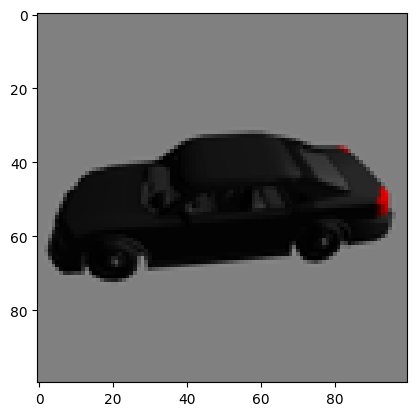

In [11]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
device = "cuda:0"
nerf = VeryTinyNeRF(device)
(images, poses, init_ds, init_o, test_img) = load_data(device)
(test_ds, test_os, test_img, train_idxs) = set_up_test_data(
    images, device, poses, init_ds, init_o
)
images = torch.Tensor(images[train_idxs])
poses = torch.Tensor(poses[train_idxs])

Loss: 0.12384132295846939


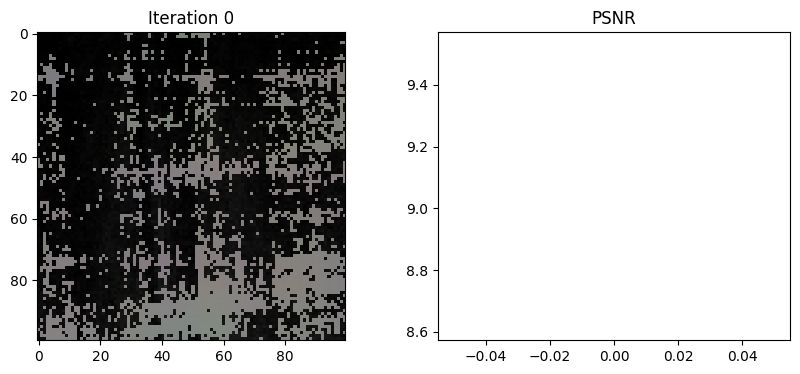

Loss: 0.010008176788687706


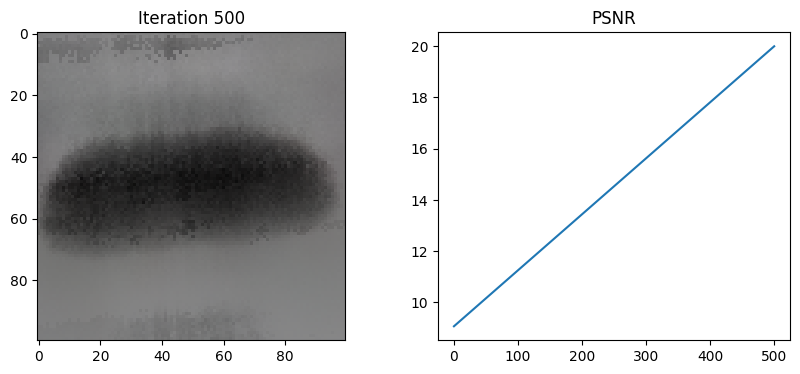

Loss: 0.006311944220215082


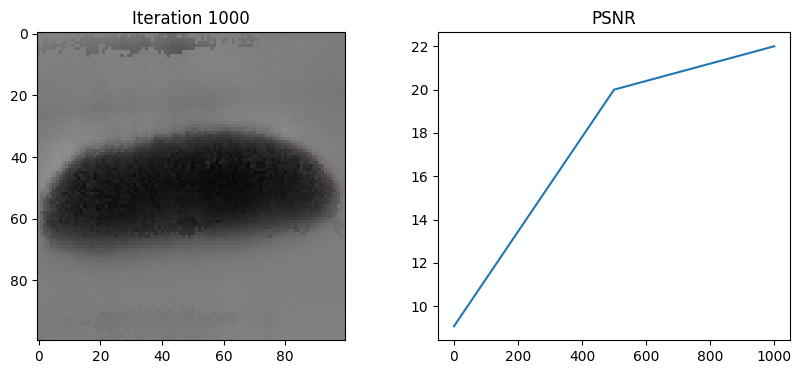

Loss: 0.004285668022930622


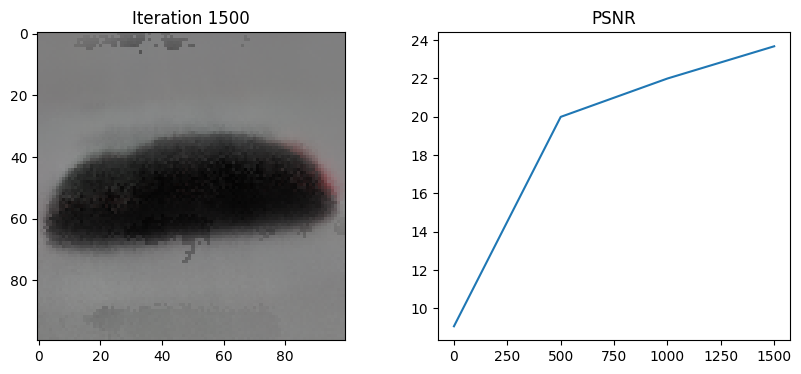

Loss: 0.004078260622918606


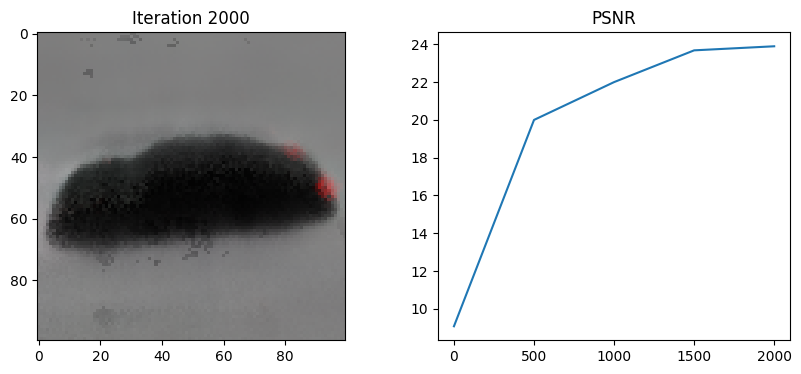

Loss: 0.002758044982329011


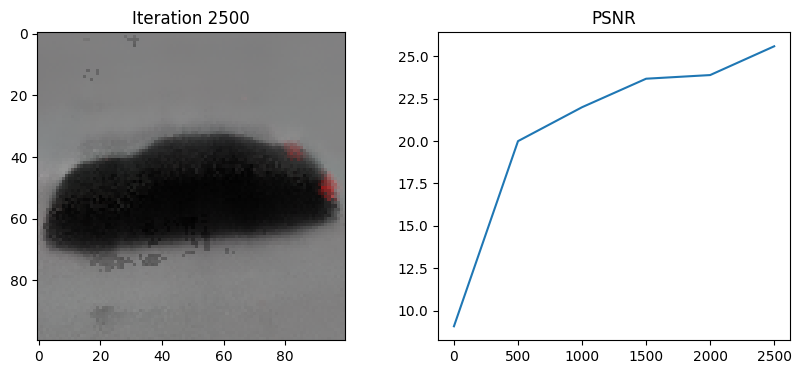

Loss: 0.0023825967218726873


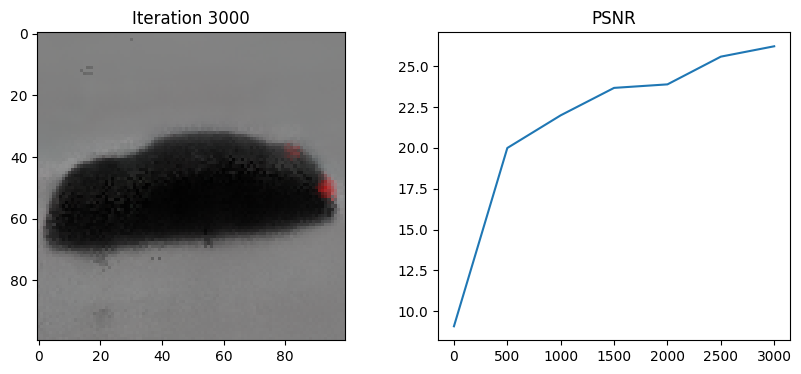

Loss: 0.002467341488227248


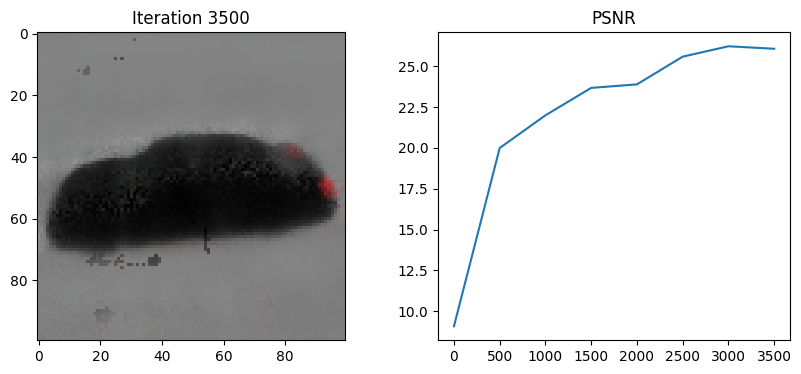

Loss: 0.0018152098637074232


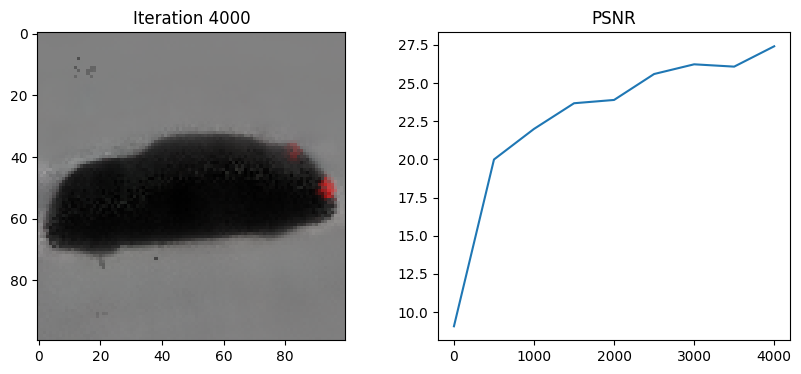

Loss: 0.001710782409645617


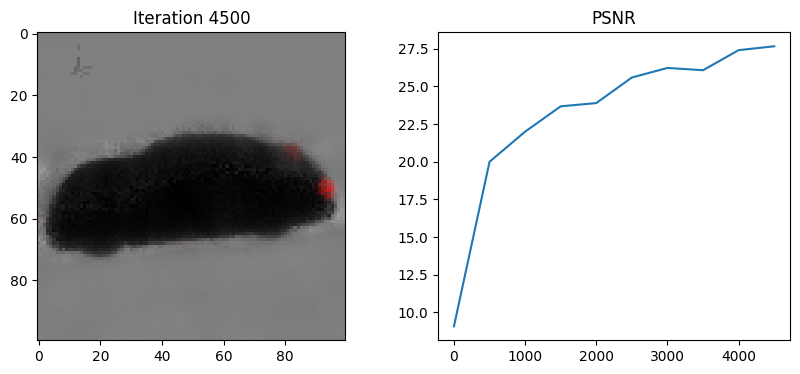

Loss: 0.00161576340906322


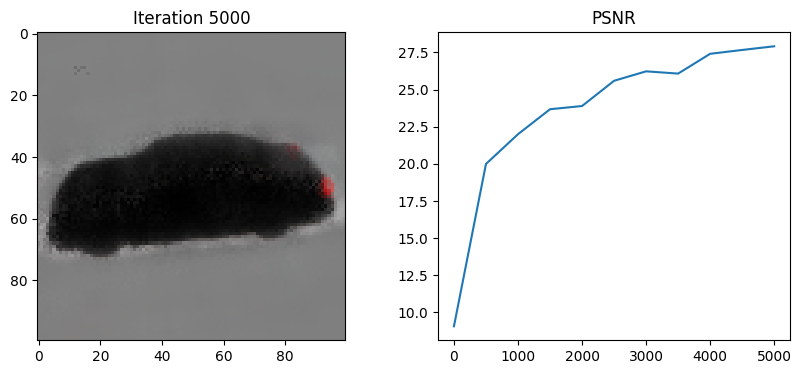

Loss: 0.0013365510385483503


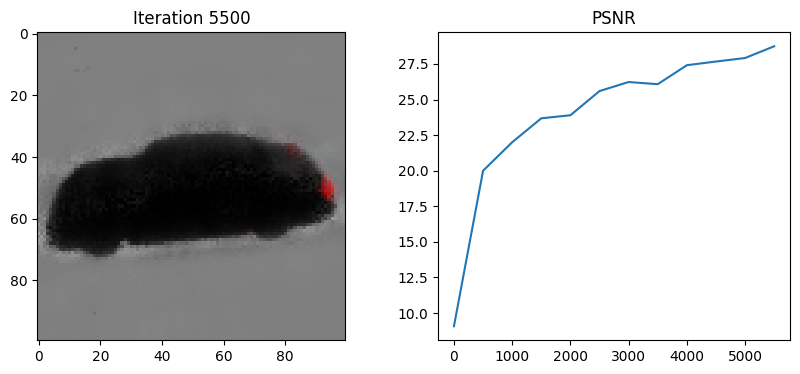

Loss: 0.0012831642525270581


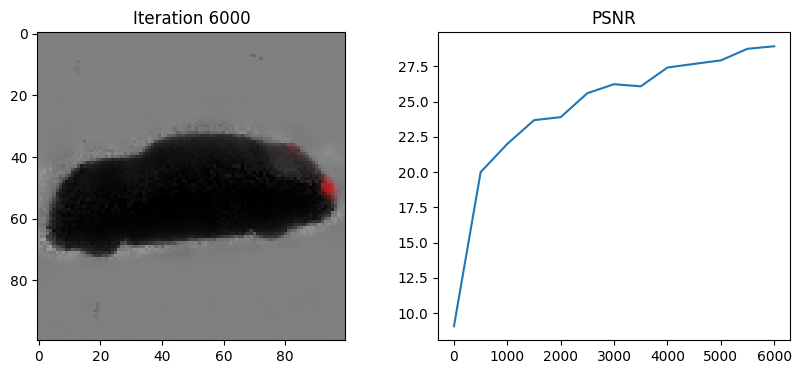

In [12]:
# 设置优化器和损失函数
optimizer = optim.Adam(nerf.F_c.parameters(), lr=0.001)
criterion = nn.MSELoss()

# 用于存储峰值信噪比（PSNR）和迭代次数
psnrs = []
iternums = []

# 设置迭代次数和显示间隔
num_iters = 20000
display_every = 500

# 将模型设置为训练模式
nerf.F_c.train()

# 开始训练循环
for i in range(num_iters):
    # 随机选择一个目标图像
    target_img_idx = np.random.randint(images.shape[0])
    target_pose = poses[target_img_idx].to(device)
    R = target_pose[:3, :3]

    # 计算目标图像的光线方向和原点
    ds = torch.einsum("ij,hwj->hwi", R, init_ds)
    os = (R @ init_o).expand(ds.shape)

    # 通过模型渲染图像
    C_rs_c = nerf(ds, os)

    # 计算损失并进行反向传播
    loss = criterion(C_rs_c, images[target_img_idx].to(device))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # 每隔一定的迭代次数显示结果
    if i % display_every == 0:
        # 将模型设置为评估模式
        nerf.F_c.eval()
        with torch.no_grad():
            # 使用测试数据进行渲染
            C_rs_c = nerf(test_ds, test_os)

        # 计算损失和PSNR
        loss = criterion(C_rs_c, test_img)
        print(f"Loss: {loss.item()}")
        psnr = -10.0 * torch.log10(loss)
        psnrs.append(psnr.item())
        iternums.append(i)

        # 显示渲染图像和PSNR曲线
        plt.figure(figsize=(10, 4))
        plt.subplot(121)
        plt.imshow(C_rs_c.detach().cpu().numpy())
        plt.title(f"Iteration {i}")
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title("PSNR")
        plt.show()

        # 将模型重新设置为训练模式
        nerf.F_c.train()